Based on this blog post: [Deriving Policy Gradients and Implementing REINFORCE](https://medium.com/@thechrisyoon/deriving-policy-gradients-and-implementing-reinforce-f887949bd63)
# REINFORCE implementation

In [1]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

# Constants
GAMMA = 0.9

class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(PolicyNetwork, self).__init__()

        self.num_actions = num_actions
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.softmax(self.linear2(x), dim=1)
        return x 
    
    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(Variable(state))
        highest_prob_action = np.random.choice(self.num_actions, p=np.squeeze(probs.detach().numpy()))
        log_prob = torch.log(probs.squeeze(0)[highest_prob_action])
        return highest_prob_action, log_prob

In [2]:
def update_policy(policy_network, rewards, log_probs):
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        pw = 0
        for r in rewards[t:]:
            Gt = Gt + GAMMA**pw * r
            pw = pw + 1
        discounted_rewards.append(Gt)
        
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9) # normalize discounted rewards

    policy_gradient = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient.append(-log_prob * Gt)
    
    policy_network.optimizer.zero_grad()
    policy_gradient = torch.stack(policy_gradient).sum()
    policy_gradient.backward()
    policy_network.optimizer.step()

In [3]:
env = gym.make('CartPole-v0')
policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 128)

max_episode_num = 500
max_steps = 10000
numsteps = []
avg_numsteps = []
all_rewards = []

for episode in range(max_episode_num):
    state = env.reset()
    log_probs = []
    rewards = []

    for steps in range(max_steps):
        env.render()
        action, log_prob = policy_net.get_action(state)
        new_state, reward, done, _ = env.step(action)
        log_probs.append(log_prob)
        rewards.append(reward)

        if done:
            update_policy(policy_net, rewards, log_probs)
            numsteps.append(steps)
            avg_numsteps.append(np.mean(numsteps[-10:]))
            all_rewards.append(np.sum(rewards))
            if episode % 1 == 0:
                sys.stdout.write("episode: {}, total reward: {}, average_reward: {}, length: {}\n".format(episode, np.round(np.sum(rewards), decimals = 3),  np.round(np.mean(all_rewards[-10:]), decimals = 3), steps))
            break

        state = new_state

plt.plot(numsteps)
plt.plot(avg_numsteps)
plt.xlabel('Episode')
plt.show()

episode: 0, total reward: 46.0, average_reward: 46.0, length: 45
episode: 1, total reward: 25.0, average_reward: 35.5, length: 24
episode: 2, total reward: 43.0, average_reward: 38.0, length: 42
episode: 3, total reward: 10.0, average_reward: 31.0, length: 9
episode: 4, total reward: 14.0, average_reward: 27.6, length: 13
episode: 5, total reward: 20.0, average_reward: 26.333, length: 19
episode: 6, total reward: 26.0, average_reward: 26.286, length: 25
episode: 7, total reward: 18.0, average_reward: 25.25, length: 17
episode: 8, total reward: 12.0, average_reward: 23.778, length: 11
episode: 9, total reward: 17.0, average_reward: 23.1, length: 16
episode: 10, total reward: 26.0, average_reward: 21.1, length: 25
episode: 11, total reward: 15.0, average_reward: 20.1, length: 14
episode: 12, total reward: 12.0, average_reward: 17.0, length: 11
episode: 13, total reward: 16.0, average_reward: 17.6, length: 15
episode: 14, total reward: 23.0, average_reward: 18.5, length: 22
episode: 15, t

episode: 126, total reward: 17.0, average_reward: 23.7, length: 16
episode: 127, total reward: 32.0, average_reward: 24.8, length: 31
episode: 128, total reward: 21.0, average_reward: 24.8, length: 20
episode: 129, total reward: 15.0, average_reward: 22.8, length: 14
episode: 130, total reward: 14.0, average_reward: 20.9, length: 13
episode: 131, total reward: 18.0, average_reward: 19.4, length: 17
episode: 132, total reward: 26.0, average_reward: 20.3, length: 25
episode: 133, total reward: 43.0, average_reward: 23.2, length: 42
episode: 134, total reward: 43.0, average_reward: 25.7, length: 42
episode: 135, total reward: 30.0, average_reward: 25.9, length: 29
episode: 136, total reward: 70.0, average_reward: 31.2, length: 69
episode: 137, total reward: 43.0, average_reward: 32.3, length: 42
episode: 138, total reward: 13.0, average_reward: 31.5, length: 12
episode: 139, total reward: 47.0, average_reward: 34.7, length: 46
episode: 140, total reward: 21.0, average_reward: 35.4, length

episode: 250, total reward: 41.0, average_reward: 27.7, length: 40
episode: 251, total reward: 59.0, average_reward: 31.6, length: 58
episode: 252, total reward: 16.0, average_reward: 31.0, length: 15
episode: 253, total reward: 23.0, average_reward: 32.0, length: 22
episode: 254, total reward: 87.0, average_reward: 37.7, length: 86
episode: 255, total reward: 44.0, average_reward: 40.3, length: 43
episode: 256, total reward: 21.0, average_reward: 37.5, length: 20
episode: 257, total reward: 20.0, average_reward: 35.2, length: 19
episode: 258, total reward: 27.0, average_reward: 35.3, length: 26
episode: 259, total reward: 39.0, average_reward: 37.7, length: 38
episode: 260, total reward: 36.0, average_reward: 37.2, length: 35
episode: 261, total reward: 20.0, average_reward: 33.3, length: 19
episode: 262, total reward: 63.0, average_reward: 38.0, length: 62
episode: 263, total reward: 19.0, average_reward: 37.6, length: 18
episode: 264, total reward: 22.0, average_reward: 31.1, length

episode: 373, total reward: 53.0, average_reward: 62.7, length: 52
episode: 374, total reward: 22.0, average_reward: 60.5, length: 21
episode: 375, total reward: 19.0, average_reward: 50.2, length: 18
episode: 376, total reward: 37.0, average_reward: 50.7, length: 36
episode: 377, total reward: 37.0, average_reward: 46.9, length: 36
episode: 378, total reward: 44.0, average_reward: 42.6, length: 43
episode: 379, total reward: 33.0, average_reward: 43.1, length: 32
episode: 380, total reward: 27.0, average_reward: 42.7, length: 26
episode: 381, total reward: 63.0, average_reward: 38.5, length: 62
episode: 382, total reward: 45.0, average_reward: 38.0, length: 44
episode: 383, total reward: 17.0, average_reward: 34.4, length: 16
episode: 384, total reward: 21.0, average_reward: 34.3, length: 20
episode: 385, total reward: 44.0, average_reward: 36.8, length: 43
episode: 386, total reward: 24.0, average_reward: 35.5, length: 23
episode: 387, total reward: 22.0, average_reward: 34.0, length

episode: 496, total reward: 58.0, average_reward: 62.1, length: 57
episode: 497, total reward: 141.0, average_reward: 71.9, length: 140
episode: 498, total reward: 158.0, average_reward: 79.9, length: 157
episode: 499, total reward: 33.0, average_reward: 80.6, length: 32
episode: 500, total reward: 82.0, average_reward: 87.3, length: 81
episode: 501, total reward: 105.0, average_reward: 77.8, length: 104
episode: 502, total reward: 25.0, average_reward: 70.2, length: 24
episode: 503, total reward: 188.0, average_reward: 87.9, length: 187
episode: 504, total reward: 139.0, average_reward: 96.8, length: 138
episode: 505, total reward: 55.0, average_reward: 98.4, length: 54
episode: 506, total reward: 45.0, average_reward: 97.1, length: 44
episode: 507, total reward: 78.0, average_reward: 90.8, length: 77
episode: 508, total reward: 42.0, average_reward: 79.2, length: 41
episode: 509, total reward: 78.0, average_reward: 83.7, length: 77
episode: 510, total reward: 120.0, average_reward: 8

episode: 617, total reward: 121.0, average_reward: 86.4, length: 120
episode: 618, total reward: 167.0, average_reward: 92.3, length: 166
episode: 619, total reward: 154.0, average_reward: 100.7, length: 153
episode: 620, total reward: 126.0, average_reward: 111.5, length: 125
episode: 621, total reward: 155.0, average_reward: 116.3, length: 154
episode: 622, total reward: 165.0, average_reward: 125.5, length: 164
episode: 623, total reward: 200.0, average_reward: 137.0, length: 199
episode: 624, total reward: 100.0, average_reward: 145.0, length: 99
episode: 625, total reward: 36.0, average_reward: 142.4, length: 35
episode: 626, total reward: 185.0, average_reward: 140.9, length: 184
episode: 627, total reward: 64.0, average_reward: 135.2, length: 63
episode: 628, total reward: 117.0, average_reward: 130.2, length: 116
episode: 629, total reward: 168.0, average_reward: 131.6, length: 167
episode: 630, total reward: 112.0, average_reward: 130.2, length: 111
episode: 631, total reward:

episode: 737, total reward: 200.0, average_reward: 163.3, length: 199
episode: 738, total reward: 200.0, average_reward: 173.7, length: 199
episode: 739, total reward: 93.0, average_reward: 163.0, length: 92
episode: 740, total reward: 152.0, average_reward: 158.2, length: 151
episode: 741, total reward: 200.0, average_reward: 166.1, length: 199
episode: 742, total reward: 200.0, average_reward: 166.1, length: 199
episode: 743, total reward: 150.0, average_reward: 161.1, length: 149
episode: 744, total reward: 180.0, average_reward: 175.1, length: 179
episode: 745, total reward: 72.0, average_reward: 162.3, length: 71
episode: 746, total reward: 200.0, average_reward: 164.7, length: 199
episode: 747, total reward: 200.0, average_reward: 164.7, length: 199
episode: 748, total reward: 177.0, average_reward: 162.4, length: 176
episode: 749, total reward: 200.0, average_reward: 173.1, length: 199
episode: 750, total reward: 188.0, average_reward: 176.7, length: 187
episode: 751, total rewa

episode: 856, total reward: 168.0, average_reward: 156.5, length: 167
episode: 857, total reward: 200.0, average_reward: 156.5, length: 199
episode: 858, total reward: 103.0, average_reward: 156.3, length: 102
episode: 859, total reward: 21.0, average_reward: 138.4, length: 20
episode: 860, total reward: 200.0, average_reward: 143.8, length: 199
episode: 861, total reward: 180.0, average_reward: 147.7, length: 179
episode: 862, total reward: 164.0, average_reward: 144.1, length: 163
episode: 863, total reward: 81.0, average_reward: 137.3, length: 80
episode: 864, total reward: 135.0, average_reward: 130.8, length: 134
episode: 865, total reward: 200.0, average_reward: 145.2, length: 199
episode: 866, total reward: 200.0, average_reward: 148.4, length: 199
episode: 867, total reward: 200.0, average_reward: 148.4, length: 199
episode: 868, total reward: 200.0, average_reward: 158.1, length: 199
episode: 869, total reward: 200.0, average_reward: 176.0, length: 199
episode: 870, total rewa

episode: 974, total reward: 200.0, average_reward: 192.4, length: 199
episode: 975, total reward: 200.0, average_reward: 199.1, length: 199
episode: 976, total reward: 186.0, average_reward: 198.6, length: 185
episode: 977, total reward: 200.0, average_reward: 198.6, length: 199
episode: 978, total reward: 179.0, average_reward: 196.5, length: 178
episode: 979, total reward: 200.0, average_reward: 196.5, length: 199
episode: 980, total reward: 200.0, average_reward: 196.5, length: 199
episode: 981, total reward: 200.0, average_reward: 196.5, length: 199
episode: 982, total reward: 200.0, average_reward: 196.5, length: 199
episode: 983, total reward: 200.0, average_reward: 196.5, length: 199
episode: 984, total reward: 200.0, average_reward: 196.5, length: 199
episode: 985, total reward: 189.0, average_reward: 195.4, length: 188
episode: 986, total reward: 200.0, average_reward: 196.8, length: 199
episode: 987, total reward: 200.0, average_reward: 196.8, length: 199
episode: 988, total 

episode: 1090, total reward: 102.0, average_reward: 152.6, length: 101
episode: 1091, total reward: 190.0, average_reward: 151.6, length: 189
episode: 1092, total reward: 200.0, average_reward: 151.6, length: 199
episode: 1093, total reward: 179.0, average_reward: 152.7, length: 178
episode: 1094, total reward: 200.0, average_reward: 168.1, length: 199
episode: 1095, total reward: 200.0, average_reward: 172.4, length: 199
episode: 1096, total reward: 192.0, average_reward: 171.6, length: 191
episode: 1097, total reward: 200.0, average_reward: 173.2, length: 199
episode: 1098, total reward: 200.0, average_reward: 176.8, length: 199
episode: 1099, total reward: 200.0, average_reward: 186.3, length: 199
episode: 1100, total reward: 200.0, average_reward: 196.1, length: 199
episode: 1101, total reward: 200.0, average_reward: 197.1, length: 199
episode: 1102, total reward: 200.0, average_reward: 197.1, length: 199
episode: 1103, total reward: 200.0, average_reward: 199.2, length: 199
episod

episode: 1206, total reward: 125.0, average_reward: 182.4, length: 124
episode: 1207, total reward: 143.0, average_reward: 176.7, length: 142
episode: 1208, total reward: 200.0, average_reward: 176.7, length: 199
episode: 1209, total reward: 200.0, average_reward: 182.2, length: 199
episode: 1210, total reward: 200.0, average_reward: 182.2, length: 199
episode: 1211, total reward: 200.0, average_reward: 182.2, length: 199
episode: 1212, total reward: 200.0, average_reward: 182.8, length: 199
episode: 1213, total reward: 200.0, average_reward: 183.0, length: 199
episode: 1214, total reward: 169.0, average_reward: 179.9, length: 168
episode: 1215, total reward: 200.0, average_reward: 183.7, length: 199
episode: 1216, total reward: 91.0, average_reward: 180.3, length: 90
episode: 1217, total reward: 171.0, average_reward: 183.1, length: 170
episode: 1218, total reward: 200.0, average_reward: 183.1, length: 199
episode: 1219, total reward: 50.0, average_reward: 168.1, length: 49
episode: 1

episode: 1323, total reward: 200.0, average_reward: 166.0, length: 199
episode: 1324, total reward: 160.0, average_reward: 167.6, length: 159
episode: 1325, total reward: 180.0, average_reward: 171.0, length: 179
episode: 1326, total reward: 200.0, average_reward: 179.1, length: 199
episode: 1327, total reward: 178.0, average_reward: 176.9, length: 177
episode: 1328, total reward: 200.0, average_reward: 185.5, length: 199
episode: 1329, total reward: 170.0, average_reward: 183.4, length: 169
episode: 1330, total reward: 180.0, average_reward: 181.4, length: 179
episode: 1331, total reward: 200.0, average_reward: 186.8, length: 199
episode: 1332, total reward: 136.0, average_reward: 180.4, length: 135
episode: 1333, total reward: 200.0, average_reward: 180.4, length: 199
episode: 1334, total reward: 191.0, average_reward: 183.5, length: 190
episode: 1335, total reward: 200.0, average_reward: 185.5, length: 199
episode: 1336, total reward: 200.0, average_reward: 185.5, length: 199
episod

episode: 1439, total reward: 167.0, average_reward: 181.8, length: 166
episode: 1440, total reward: 200.0, average_reward: 181.8, length: 199
episode: 1441, total reward: 200.0, average_reward: 181.8, length: 199
episode: 1442, total reward: 200.0, average_reward: 190.0, length: 199
episode: 1443, total reward: 118.0, average_reward: 181.8, length: 117
episode: 1444, total reward: 200.0, average_reward: 183.3, length: 199
episode: 1445, total reward: 191.0, average_reward: 182.4, length: 190
episode: 1446, total reward: 200.0, average_reward: 182.4, length: 199
episode: 1447, total reward: 200.0, average_reward: 187.6, length: 199
episode: 1448, total reward: 200.0, average_reward: 187.6, length: 199
episode: 1449, total reward: 177.0, average_reward: 188.6, length: 176
episode: 1450, total reward: 180.0, average_reward: 186.6, length: 179
episode: 1451, total reward: 118.0, average_reward: 178.4, length: 117
episode: 1452, total reward: 48.0, average_reward: 163.2, length: 47
episode:

episode: 1555, total reward: 200.0, average_reward: 156.9, length: 199
episode: 1556, total reward: 200.0, average_reward: 161.9, length: 199
episode: 1557, total reward: 200.0, average_reward: 161.9, length: 199
episode: 1558, total reward: 200.0, average_reward: 161.9, length: 199
episode: 1559, total reward: 200.0, average_reward: 161.9, length: 199
episode: 1560, total reward: 200.0, average_reward: 172.2, length: 199
episode: 1561, total reward: 200.0, average_reward: 172.6, length: 199
episode: 1562, total reward: 171.0, average_reward: 180.4, length: 170
episode: 1563, total reward: 141.0, average_reward: 181.0, length: 140
episode: 1564, total reward: 188.0, average_reward: 190.0, length: 187
episode: 1565, total reward: 200.0, average_reward: 190.0, length: 199
episode: 1566, total reward: 200.0, average_reward: 190.0, length: 199
episode: 1567, total reward: 179.0, average_reward: 187.9, length: 178
episode: 1568, total reward: 200.0, average_reward: 187.9, length: 199
episod

episode: 1671, total reward: 200.0, average_reward: 198.3, length: 199
episode: 1672, total reward: 141.0, average_reward: 192.4, length: 140
episode: 1673, total reward: 200.0, average_reward: 192.4, length: 199
episode: 1674, total reward: 200.0, average_reward: 192.4, length: 199
episode: 1675, total reward: 200.0, average_reward: 192.4, length: 199
episode: 1676, total reward: 200.0, average_reward: 194.1, length: 199
episode: 1677, total reward: 200.0, average_reward: 194.1, length: 199
episode: 1678, total reward: 200.0, average_reward: 194.1, length: 199
episode: 1679, total reward: 172.0, average_reward: 191.3, length: 171
episode: 1680, total reward: 200.0, average_reward: 191.3, length: 199
episode: 1681, total reward: 200.0, average_reward: 191.3, length: 199
episode: 1682, total reward: 200.0, average_reward: 197.2, length: 199
episode: 1683, total reward: 129.0, average_reward: 190.1, length: 128
episode: 1684, total reward: 200.0, average_reward: 190.1, length: 199
episod

episode: 1787, total reward: 200.0, average_reward: 196.7, length: 199
episode: 1788, total reward: 176.0, average_reward: 194.3, length: 175
episode: 1789, total reward: 200.0, average_reward: 194.3, length: 199
episode: 1790, total reward: 200.0, average_reward: 194.3, length: 199
episode: 1791, total reward: 200.0, average_reward: 194.3, length: 199
episode: 1792, total reward: 200.0, average_reward: 194.3, length: 199
episode: 1793, total reward: 200.0, average_reward: 194.3, length: 199
episode: 1794, total reward: 200.0, average_reward: 194.3, length: 199
episode: 1795, total reward: 126.0, average_reward: 190.2, length: 125
episode: 1796, total reward: 200.0, average_reward: 190.2, length: 199
episode: 1797, total reward: 200.0, average_reward: 190.2, length: 199
episode: 1798, total reward: 200.0, average_reward: 192.6, length: 199
episode: 1799, total reward: 200.0, average_reward: 192.6, length: 199
episode: 1800, total reward: 200.0, average_reward: 192.6, length: 199
episod

episode: 1903, total reward: 145.0, average_reward: 185.2, length: 144
episode: 1904, total reward: 200.0, average_reward: 185.2, length: 199
episode: 1905, total reward: 200.0, average_reward: 185.2, length: 199
episode: 1906, total reward: 200.0, average_reward: 185.2, length: 199
episode: 1907, total reward: 200.0, average_reward: 185.2, length: 199
episode: 1908, total reward: 200.0, average_reward: 185.2, length: 199
episode: 1909, total reward: 190.0, average_reward: 184.2, length: 189
episode: 1910, total reward: 200.0, average_reward: 184.2, length: 199
episode: 1911, total reward: 200.0, average_reward: 184.2, length: 199
episode: 1912, total reward: 200.0, average_reward: 193.5, length: 199
episode: 1913, total reward: 200.0, average_reward: 199.0, length: 199
episode: 1914, total reward: 200.0, average_reward: 199.0, length: 199
episode: 1915, total reward: 200.0, average_reward: 199.0, length: 199
episode: 1916, total reward: 200.0, average_reward: 199.0, length: 199
episod

KeyboardInterrupt: 

# Original Swingup

In [5]:
from environments.swingup import CartPoleSwingUp
env = CartPoleSwingUp()
policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 128)

max_episode_num = 500
max_steps = 10000
numsteps = []
avg_numsteps = []
all_rewards = []

for episode in range(max_episode_num):
    state = env.reset()
    log_probs = []
    rewards = []

    for steps in range(max_steps):
        env.render()
        action, log_prob = policy_net.get_action(state)
        new_state, reward, done, _ = env.step(action)
        log_probs.append(log_prob)
        rewards.append(reward)

        if done:
            update_policy(policy_net, rewards, log_probs)
            numsteps.append(steps)
            avg_numsteps.append(np.mean(numsteps[-10:]))
            all_rewards.append(np.sum(rewards))
            if episode % 1 == 0:
                sys.stdout.write("episode: {}, total reward: {}, average_reward: {}, length: {}\n".format(episode, np.round(np.sum(rewards), decimals = 3),  np.round(np.mean(all_rewards[-10:]), decimals = 3), steps))
            break

        state = new_state

plt.plot(numsteps)
plt.plot(avg_numsteps)
plt.xlabel('Episode')
plt.show()

episode: 0, total reward: -10.0, average_reward: -10.0, length: 286


/usr/local/anaconda3/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


episode: 1, total reward: -10.0, average_reward: -10.0, length: 250
episode: 2, total reward: -10.0, average_reward: -10.0, length: 350
episode: 3, total reward: -10.0, average_reward: -10.0, length: 147
episode: 4, total reward: -10.0, average_reward: -10.0, length: 295
episode: 5, total reward: -10.0, average_reward: -10.0, length: 299
episode: 6, total reward: -10.0, average_reward: -10.0, length: 293
episode: 7, total reward: -10.0, average_reward: -10.0, length: 107
episode: 8, total reward: -10.0, average_reward: -10.0, length: 210
episode: 9, total reward: -10.0, average_reward: -10.0, length: 354
episode: 10, total reward: -10.0, average_reward: -10.0, length: 160
episode: 11, total reward: -10.0, average_reward: -10.0, length: 182
episode: 12, total reward: -10.0, average_reward: -10.0, length: 337
episode: 13, total reward: -10.0, average_reward: -10.0, length: 281
episode: 14, total reward: -10.0, average_reward: -10.0, length: 292
episode: 15, total reward: -10.0, average_r

episode: 121, total reward: 26.0, average_reward: 11.3, length: 625
episode: 122, total reward: 2.0, average_reward: 12.0, length: 179
episode: 123, total reward: 8.0, average_reward: 12.7, length: 405
episode: 124, total reward: -3.0, average_reward: 13.0, length: 412
episode: 125, total reward: -4.0, average_reward: 11.5, length: 435
episode: 126, total reward: -1.0, average_reward: 12.4, length: 294
episode: 127, total reward: 8.0, average_reward: 4.7, length: 803
episode: 128, total reward: 17.0, average_reward: 6.4, length: 396
episode: 129, total reward: -3.0, average_reward: 5.9, length: 455
episode: 130, total reward: -3.0, average_reward: 4.7, length: 420
episode: 131, total reward: -4.0, average_reward: 1.7, length: 236
episode: 132, total reward: -10.0, average_reward: 0.5, length: 197
episode: 133, total reward: 4.0, average_reward: 0.1, length: 430
episode: 134, total reward: 0.0, average_reward: 0.4, length: 210
episode: 135, total reward: 110.0, average_reward: 11.8, len

KeyboardInterrupt: 

In [6]:
env.close()

# Rotational cartpole

In [3]:
import gym
from gym import logger
import numpy as np
from math import log, exp
from tqdm.notebook import tqdm , trange

class CartPoleRot(gym.Wrapper):
    def __init__(self, env=gym.make('CartPole-v1'), **kwargs):
        super(CartPoleRot, self).__init__(env, **kwargs)
        self.theta_dot_r_factor = 1000

    def reset(self):
        self.env.env.state = [0, 0, np.pi, 0] + super().reset()
        return np.array(self.env.env.state)

    def step(self, action):
        state, reward, done, _ = super().step(action)
        self.env.env.steps_beyond_done = None
        x, x_dot, theta, theta_dot = state
        theta = (theta+np.pi)%(2*np.pi)-np.pi
        self.env.env.state = [x, x_dot, theta, theta_dot]
        
        done = x < -self.x_threshold \
               or x > self.x_threshold 
        
        if done:
            # game over
            reward = -10.
            if self.steps_beyond_done is None:
                self.steps_beyond_done = 0
            elif self.steps_beyond_done == 0:
                logger.warn("You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.")
                self.steps_beyond_done += 1
        else:
            if abs(theta_dot) > 0:
                # pole rotation
                reward = self.theta_dot_r_factor * abs(theta_dot) - x_dot**4 - 0.01*x**2
#                 - 100*log(abs(x))
            else:
                # pole not rotating
                reward = 0

        return np.array([x, x_dot, theta, theta_dot]), reward, done, {}

In [4]:
env = CartPoleRot()
policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 128)

max_episode_num = 200
max_steps = 2000
numsteps = []
avg_numsteps = []
all_rewards = []
tbar = trange(max_episode_num, desc='desc', leave=True)
for episode in tbar:
    state = env.reset()
    log_probs = []
    rewards = []

    for steps in range(max_steps):
        env.render()
        action, log_prob = policy_net.get_action(state)
        new_state, reward, done, _ = env.step(action)
        log_probs.append(log_prob)
        rewards.append(reward)

        if done:
            update_policy(policy_net, rewards, log_probs)
            numsteps.append(steps)
            avg_numsteps.append(np.mean(numsteps[-10:]))
            all_rewards.append(np.sum(rewards))
            if episode % 1 == 0:
                tbar.set_description(f"#{episode} tot_r: {np.sum(rewards):.0f}, avg_r: {np.mean(all_rewards[-10:]):.0f}, steps: {steps}\n")
#                 tqdm.write("episode: {}, total reward: {}, average_reward: {}, length: {}\n".format(episode, np.round(np.sum(rewards), decimals = 3),  np.round(np.mean(all_rewards[-10:]), decimals = 3), steps))
#                 sys.stdout.write("episode: {}, total reward: {}, average_reward: {}, length: {}\n".format(episode, np.round(np.sum(rewards), decimals = 3),  np.round(np.mean(all_rewards[-10:]), decimals = 3), steps))
            break

        state = new_state

env.close()

/usr/local/anaconda3/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


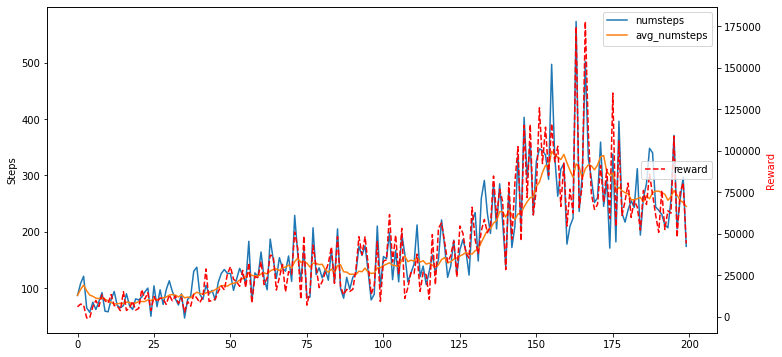

In [5]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
ax1.plot(numsteps, label="numsteps")
ax1.plot(avg_numsteps, label="avg_numsteps")
ax2.plot(all_rewards, 'r--', label="reward")
ax1.set_ylabel('Steps')
ax2.set_ylabel('Reward', color='r')
plt.xlabel('Episode')
ax1.legend()
ax2.legend(loc='center right')
plt.show()


In [53]:
env.close()

# A2C
Based on [Understanding Actor Critic Methods and A2C](https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f)

In [18]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd

# hyperparameters
hidden_size = 256
learning_rate = 3e-4

# Constants
GAMMA = 0.99
num_steps = 500
max_episodes = 2000

In [19]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 1)

        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, num_actions)
    
    def forward(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        value = F.relu(self.critic_linear1(state))
        value = self.critic_linear2(value)
        
        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = F.softmax(self.actor_linear2(policy_dist), dim=1)

        return value, policy_dist

In [20]:
# Define env
env = CartPoleRot()
# Start a2c
num_inputs = env.observation_space.shape[0]
num_outputs = env.action_space.n

actor_critic = ActorCritic(num_inputs, num_outputs, hidden_size)
ac_optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)

all_lengths = []
average_lengths = []
all_rewards = []
entropy_term = 0

for episode in trange(max_episodes):
    log_probs = []
    values = []
    rewards = []

    state = env.reset()
    for steps in range(num_steps):
        value, policy_dist = actor_critic.forward(state)
        value = value.detach().numpy()[0,0]
        dist = policy_dist.detach().numpy() 

        action = np.random.choice(num_outputs, p=np.squeeze(dist))
        log_prob = torch.log(policy_dist.squeeze(0)[action])
        entropy = -np.sum(np.mean(dist) * np.log(dist))
        new_state, reward, done, _ = env.step(action)

        rewards.append(reward)
        values.append(value)
        log_probs.append(log_prob)
        entropy_term += entropy
        state = new_state

        if done or steps == num_steps-1:
            Qval, _ = actor_critic.forward(new_state)
            Qval = Qval.detach().numpy()[0,0]
            all_rewards.append(np.sum(rewards))
            all_lengths.append(steps)
            average_lengths.append(np.mean(all_lengths[-10:]))
            if episode % 100 == 0:                    
                tqdm.write("episode: {}, reward: {}, total length: {}, average length: {} \n".format(episode, np.sum(rewards), steps, average_lengths[-1]))
            break

    # compute Q values
    Qvals = np.zeros_like(values)
    for t in reversed(range(len(rewards))):
        Qval = rewards[t] + GAMMA * Qval
        Qvals[t] = Qval

    #update actor critic
    values = torch.FloatTensor(values)
    Qvals = torch.FloatTensor(Qvals)
    log_probs = torch.stack(log_probs)

    advantage = Qvals - values
    actor_loss = (-log_probs * advantage).mean()
    critic_loss = 0.5 * advantage.pow(2).mean()
    ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

    ac_optimizer.zero_grad()
    ac_loss.backward()
    ac_optimizer.step()

episode: 0, reward: 131275.74985969212, total length: 121, average length: 121.0 

episode: 50, reward: 57023.45169602842, total length: 55, average length: 66.7 

episode: 100, reward: 50000.45477963635, total length: 50, average length: 64.4 

episode: 150, reward: 744656.0033660078, total length: 181, average length: 98.4 

episode: 200, reward: 286343.30151951464, total length: 107, average length: 67.6 

episode: 250, reward: 62995.44382829326, total length: 42, average length: 61.9 

episode: 300, reward: 266891.3750781364, total length: 119, average length: 70.9 

episode: 350, reward: 64514.76598457194, total length: 40, average length: 56.6 

episode: 400, reward: 274158.6885030688, total length: 114, average length: 70.7 

episode: 450, reward: 63530.37857942399, total length: 40, average length: 53.2 

episode: 500, reward: 65294.746254657235, total length: 40, average length: 70.0 

episode: 550, reward: 55778.195606366746, total length: 39, average length: 76.9 

episode: 

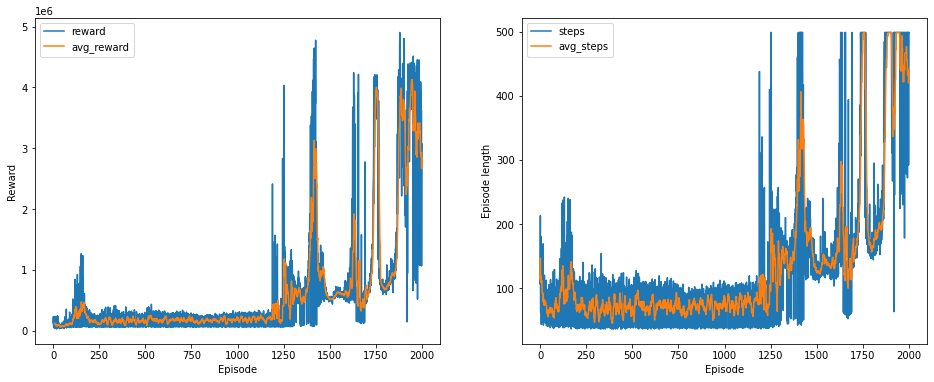

In [21]:
# Plot results
smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
smoothed_rewards = [elem for elem in smoothed_rewards]
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(all_rewards, label="reward")
plt.plot(smoothed_rewards, label="avg_reward")
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()

plt.subplot(1,2,2)
plt.plot(all_lengths, label="steps")
plt.plot(average_lengths, label="avg_steps")
plt.xlabel('Episode')
plt.ylabel('Episode length')
plt.legend()
plt.show()

In [26]:
state = env.reset()
env.render()
for i in range(100000):
    _value, policy_dist = actor_critic.forward(state)
    a = np.argmax(policy_dist.detach().numpy())
    y, _, d, _ = env.step(a)
    env.render()
    state=y
    if d:
        print(i)
        break

env.close()

In [ ]:
env = gym.make("CartPole-v0")
a2c(env)    